# Machine Learning Homework 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mat4py import loadmat
from scipy.linalg import orth, sqrtm
from scipy.stats import norm
from scipy.ndimage import imread
from itertools import product

## Problem 1: Factor Analysis

### Part A. 
a). Derive an expression for the number of independent parameters in the factor analysis model. 

Consider the general expression for the Factor Analysis Model, 

$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0)$

$p(\mathbf{x}_i|\mathbf{z}_i, \boldsymbol{\Theta}) = \mathcal{N}(\mathbf{W}\mathbf{z}_i + \boldsymbol{\mu}, \boldsymbol{\Psi})$

The parameters in the prior can be absorbed into the likelihood without losing generality, so the independent parameters include only $\mathbf{W} [D\times L],\ \boldsymbol{\mu} [L\times 1],\ \boldsymbol{\Psi} [L]$, therefore, the total number of independent parameters is $(D+2)\times L$

b). Show that the factor analysis model is invariant under rotations of the latent space coordinates. 

In the FA model, the marginal likelihood of $\mathbf{x}$ can be represented through the covariance matrix. 

Define an orthogonal rotation matrix $\mathbf{R}$ such that $\mathbf{R}\mathbf{R}^T = \mathbf{I}$, and define $\hat{\mathbf{W}} = \mathbf{W}\mathbf{R}$, the modiflied covariance is the same as the original one since the covariance remains the same. 

## Part B: Perform FA analysis on given data

In [2]:
p1_data = loadmat('Resources/P1/04cars.mat')

In [3]:
print(p1_data.keys())

dict_keys(['X', 'names', 'types', 'varlabels'])


In [4]:
X = np.array(p1_data['X']).T
names = np.array(p1_data['names'])
types = p1_data['types']
varlabels = p1_data['varlabels']

In [5]:
print(X.shape)
print(names.shape)
print(types)
print(varlabels)

(18, 387)
(387, 1)
bbbbbbbccccccccccc
['Sports', 'SUV', 'Wagon', 'Minivan', 'Pickup', 'AWD', 'RWD', 'Retail', 'Dealer', 'Engine', 'Cylinders', 'Horsepower', 'CityMPG', 'HighwayMPG', 'Weight', 'Wheelbase', 'Length', 'Width']


#### Perform EM algorithm
FA analysis is done here with EM algorithm. Details are described below. 

We initialise with parameters, 
* $\mathbf{W}$: factor loading matrix
* $\boldsymbol{\Psi}$: D by D diagonal covariance matrix

In the E step, we compute the posterior probability, 

\begin{align}
p(\mathbf{z}_i|\mathbf{x}_i,\boldsymbol{\Theta}) &= \mathcal{N}(\mathbf{z}_i|\mathbf{m}_i, \boldsymbol{\Sigma})\\
\boldsymbol{\Sigma} &= (\mathbf{I}_L + \mathbf{W}^T\boldsymbol{\Psi}^{-1}\mathbf{W})^{-1}\\
\mathbf{m}_i &= \boldsymbol{\Sigma}(\mathbf{W}^T\boldsymbol{|Psi}^{-1}(\mathbf{x}_i - \mu))
\end{align}

Then in the M step, for computational convinience, we define $\hat{\mathbf{W}} = (\mathbf{W}, \boldsymbol{\mu})$ and $\hat{\mathbf{z}} = (\mathbf{z};1)$, and we also define, 
\begin{align}
\mathbf{b}_i &= \mathbb{E}[\mathbf{z}_i|\mathbf{x}_i] = [\mathbf{m}_i;1]\\
\mathbf{C}_i &= \mathbb{E}[\mathbf{z}_i\mathbf{z}_i^T|\mathbf{x}_i]
\end{align}

Then we can compute the parameters, 
\begin{align}
\hat{\mathbf{W}} &= [\sum_i \mathbf{x}_i\mathbf{b}_i^T][\sum_i \mathbf{C}_i]^{-1}\\
\hat{\boldsymbol{\Psi}} &= \frac{1}{N}\text{diag}\{\sum_i (\mathbf{x}_i - \hat{\mathbf{W}}\mathbf{b}_i)\mathbf{x}_i^T\}
\end{align}

In [6]:
N = X.shape[1]
D = X.shape[0]
L = 2

# Initialise W and Psi
W = np.random.rand(D*L).reshape(D,L)
Psi = np.diag(np.random.rand(D))

# Initialise containers
Sigma = np.zeros((L,L,N))
m = np.zeros((L,1,N))
b = np.zeros((L+1,1,N))
C = np.zeros((L+1, L+1,N))

# convinient container
b_i = np.ones((L+1, 1))
C_i = np.ones((L+1, L+1))

In [7]:
mu = np.mean(X, axis=1).reshape(D,1)
Xc = np.subtract(X,mu)

In [8]:
tol = 1.0
incre = 100
counter = 0
while True:
    for i in range(N):
        # E Step
        x_i = X[:,i:i+1]
        xc_i = x_i - mu
        beta = W.T @ np.linalg.inv(Psi + W @ W.T)
        sigma_i = np.eye(L) - beta @ xc_i @ xc_i.T @ beta.T
        m_i = beta @ xc_i

        # M Step
        W_hat = np.concatenate([W,mu], axis=1)

        b_i[:L,0:0+1] = m_i
        C_i[0:L,0:L] = sigma_i + m_i @ m_i.T
        C_i[:L,L:L+1] = m_i
        C_i[L:L+1,:L] = m_i.T

        # put to containers
        Sigma[:,:,i] = sigma_i
        m[:,:,i] = m_i
        b[:,:,i] = b_i
        C[:,:,i] = C_i 

    W_hat_new = np.sum(np.array([X[:,i:i+1] @ b[:,:,i].T for i in range(N)]),axis=0) @ np.linalg.inv(np.sum(C, axis=2)) + 1e-10
    W_new = W_hat_new[:,:L]
    mu_new = W_hat_new[:,L:L+1] + 1e-10
    Psi_new = 1/N * np.diag(np.diag(np.sum(np.array([ (X[:,i:i+1]-W_hat_new @ b[:,:,i]) @ X[:,i:i+1].T for i in range(N)]), axis=0)))
    Psi_new += 1e-10 # a small number is added to avoid singular matrix
    # compute increment with square sum
    incre = (np.sqrt(np.sum((W_new.flatten()-W.flatten())**2)) + np.sqrt(np.sum((Psi_new.flatten() - Psi.flatten())**2)))/(D*L + D)
    counter += 1
    if incre > tol:
        W = W_new
        mu = mu_new
        Psi = Psi_new
    else:
        print("Total number of iteration: {}".format(counter))
        W = W_new
        mu = mu_new
        Psi = Psi_new
        break

Total number of iteration: 963


Now we plot both the scores of data and the unit vectors to each of the feature dimension in the low dimensional space. 

In [9]:
Z = np.linalg.inv(W.T @ W) @ W.T @ (X-mu)
print(Z.shape)

# normalise W
V = np.array([W[i,:]/np.sqrt(np.sum(W[i,:]**2)) for i in range(D)])

(2, 387)


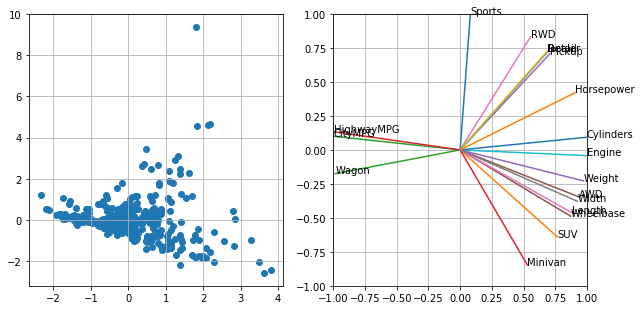

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].scatter(Z[0,:], Z[1,:])
axes[0].grid()

for i in range(D):
    axes[1].plot([0,V[i,0]], [0,V[i,1]])
    axes[1].text(V[i,0],V[i,1],varlabels[i])
axes[1].set_xlim([-1,1])
axes[1].set_ylim([-1,1])
axes[1].grid()

## Problem 2: PCA and KPCA

### Part A
Show the the maximum likelihood solution is covariant under re-scaling of the data variables. 

If we consider the transformation $\mathbf{z} \to \mathbf{A}\mathbf{x}$, then if we consider the likelihood of the transformed data, 
\begin{align}
p(\mathbf{A}\mathbf{x}|\boldsymbol{\theta}) &= \int \mathcal{N}(\mathbf{A}\mathbf{x}|\mathbf{A}(\mathbf{W}\mathbf{z}+\boldsymbol{\mu}),\mathbf{A}\boldsymbol{\Phi}\mathbf{A}^T)\mathcal{N}(\mathbf{z}|\mathbf{0},\mathbf{I})d\mathbf{z}\\
&\propto \exp\{-\frac{1}{2}\frac{(\mathbf{W}\mathbf{z}+\boldsymbol{\mu})^T\mathbf{A}^T\mathbf{A}(\mathbf{W}\mathbf{z}+\boldsymbol{\mu})}{\mathbf{A}\mathbf{\Phi}\mathbf{A}^T}\}
\end{align}

From which we can observe that the effect of the transformation is neutralised in the marginal probability. Therefore, there is no variation for the MLE solution of the parameters. Since this is a general proof, the conclusion carries to part a and b. 


### Part B
Compute the first 8 kernel principal component basis functions. Use RBF kernel with $\sigma^2 = 0.1$

In [11]:
p2_data = loadmat('Resources/P2/Problem2.mat')
print(p2_data.keys())

dict_keys(['patterns', 'test_patterns'])


In [12]:
patterns = np.array(p2_data['patterns'])
test_patterns = np.array(p2_data['test_patterns'])

In [13]:
print(patterns.shape)
print(test_patterns.shape)

(90, 2)
(225, 2)


In [14]:
sigma = 0.05
M = 8
N = patterns.shape[0]
N1 = test_patterns.shape[0]

# compute kernel matrix K
def k(x1,x2):
    # x1 and x2 are 1d arrays
    enorm = np.sqrt(np.sum((x1-x2)**2))  
    return np.exp(-enorm/2*sigma)
K = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = k(patterns[i,:], patterns[j,:])
K1 = np.zeros((N1,N))
for i in range(N1):
    for j in range(N):
        K1[i,j] = k(test_patterns[i,:], patterns[j,:])

OneN = 1/N * np.ones((N,N))
K_t = K - OneN @ K - K @ OneN + OneN @ K @ OneN
A, U = np.linalg.eig(K_t)

U_m = U[:,:M]
V = np.zeros(U_m.shape)
for i in range(M):
    V[:,i] = U_m[:,i] / np.sqrt(A[i])

K_t1 = K1 - 1/N * K1 @ np.ones((N,1)) - 1/N1 * np.ones((1,N1)) @ K1 + 1/(N*N1) * np.sum(K1)
Z = K_t1 @ V

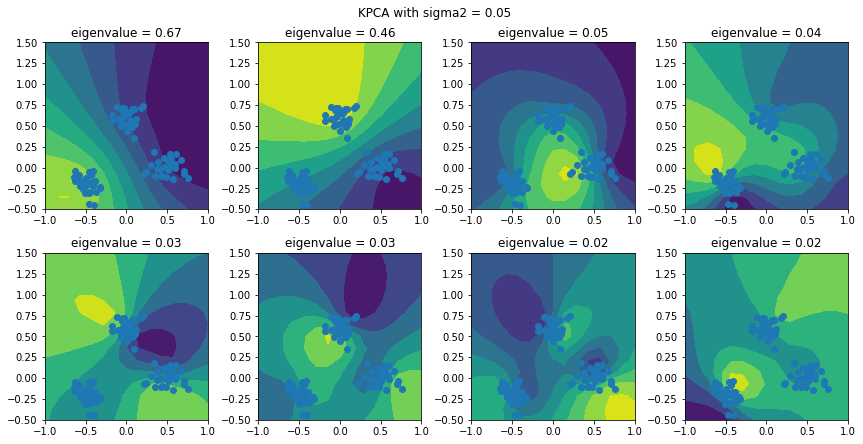

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
for i in range(2):
    for j in range(4):  
        axes[i,j].contourf(test_patterns[:,0].reshape(15,15), test_patterns[:,1].reshape(15,15), Z[:,i*4+j].reshape(15,15))
        axes[i,j].scatter(patterns[:,0],patterns[:,1])
        axes[i,j].set_title("eigenvalue = {:4.2f}".format(A[i*4 + j]))
fig.suptitle("KPCA with sigma2 = 0.05",y=1.02)
plt.tight_layout()

In [16]:
sigma = 5
M = 8
N = patterns.shape[0]
N1 = test_patterns.shape[0]

# compute kernel matrix K
def k(x1,x2):
    # x1 and x2 are 1d arrays
    enorm = np.sqrt(np.sum((x1-x2)**2))  
    return np.exp(-enorm/2*sigma)
K = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        K[i,j] = k(patterns[i,:], patterns[j,:])
K1 = np.zeros((N1,N))
for i in range(N1):
    for j in range(N):
        K1[i,j] = k(test_patterns[i,:], patterns[j,:])

OneN = 1/N * np.ones((N,N))
K_t = K - OneN @ K - K @ OneN + OneN @ K @ OneN
A, U = np.linalg.eig(K_t)

U_m = U[:,:M]
V = np.zeros(U_m.shape)
for i in range(M):
    V[:,i] = U_m[:,i] / np.sqrt(A[i])

K_t1 = K1 - 1/N * K1 @ np.ones((N,1)) - 1/N1 * np.ones((1,N1)) @ K1 + 1/(N*N1) * np.sum(K1)
Z = K_t1 @ V

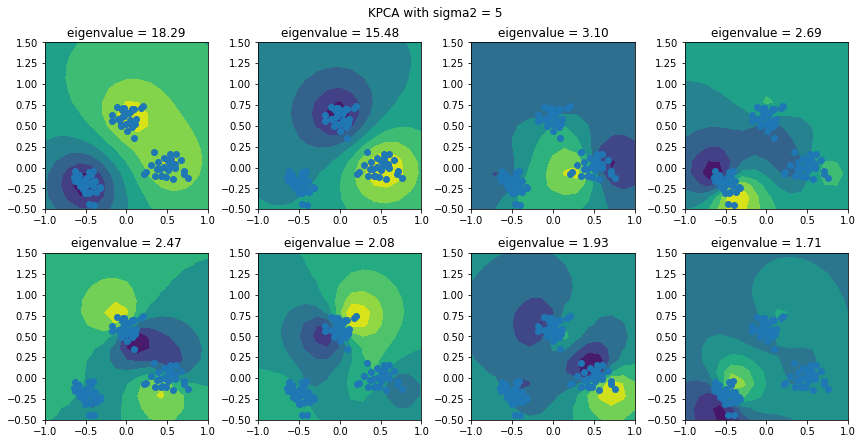

In [17]:
# for data scaled with 100
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
for i in range(2):
    for j in range(4):  
        axes[i,j].contourf(test_patterns[:,0].reshape(15,15), test_patterns[:,1].reshape(15,15), Z[:,i*4+j].reshape(15,15))
        axes[i,j].scatter(patterns[:,0],patterns[:,1])
        axes[i,j].set_title("eigenvalue = {:4.2f}".format(A[i*4 + j]))
fig.suptitle("KPCA with sigma2 = 5",y=1.02)
plt.tight_layout()

So it can be observed that the with greater $\sigma^2$ value in KPCA, there is a stronger performance in the outcome. 

## Problem 3: Independent Component Analysis

### Part A: Proof that zero correlation is not a sufficient condition for independence

For two indepdent variables $z_1,z_2$, let's denote $\mathbf{z} = \{z_1, z_2\}^T$. Then the covariance matrix is analyzed as below, 
\begin{align}
\text{cov}[\mathbf{z}] &= \mathbb{E}[z_i z_j] - \mathbb{E}[z_i]\mathbb{E}[z_j]
\end{align}
So, we can see that when $i\neq j$, the covariance is zero and when $i=j$, it is non-zero. 

Now let's move on to two variables $y_1$ and $y_2$ where $-1\leq y_1 \leq 1$ and $y_2 = y_1^2$. The conditional probability can be written as, 
\begin{equation}
p(y_2|y_1) = \frac{p(y_2,y_1)}{p(y_1)} = \frac{p(y_1^2, y_1)}{p(y_1)}
\end{equation}
which essentially depends on $y_1$. If we consider the covariance, again we denote $\mathbf{y} = \{y_1, y_2\}^T$, we have, 
\begin{align}
\text{cov}[\mathbf{y}] &= \mathbb{E}[y_iy_j] - \mathbb{E}[y_i]\mathbb{E}[y_j]\\
&= \mathbb{E}[y_1 y_2] - \mathbb{E}[y_1]\mathbb{E}[y_2]\\
&= \mathbb{E}[y_1^3] - \mathbb{E}[y_1]\mathbb{E}[y_1^2]\ \ \text{if $i\neq j$}\\
&= 0
\end{align}
Therefore we can see that zero correlation is not a sufficient condition for independence. 

### Part B: For some noisy observations of a 4D signal, use ICA to reconstruct the signal. 

In [18]:
p3_data = loadmat('Resources/P3/Problem3.mat')
print(p3_data.keys())

dict_keys(['mixedsig', 'sigTrue'])


In [19]:
mixedsig = np.array(p3_data['mixedsig'])
sigTrue = np.array(p3_data['sigTrue'])
D,N = mixedsig.shape
print("Shape of mixedsig: {}".format(mixedsig.shape))
print("Shape of sigTrue: {}".format(sigTrue.shape))

Shape of mixedsig: (4, 500)
Shape of sigTrue: (4, 500)


Do some initial observation of the data.

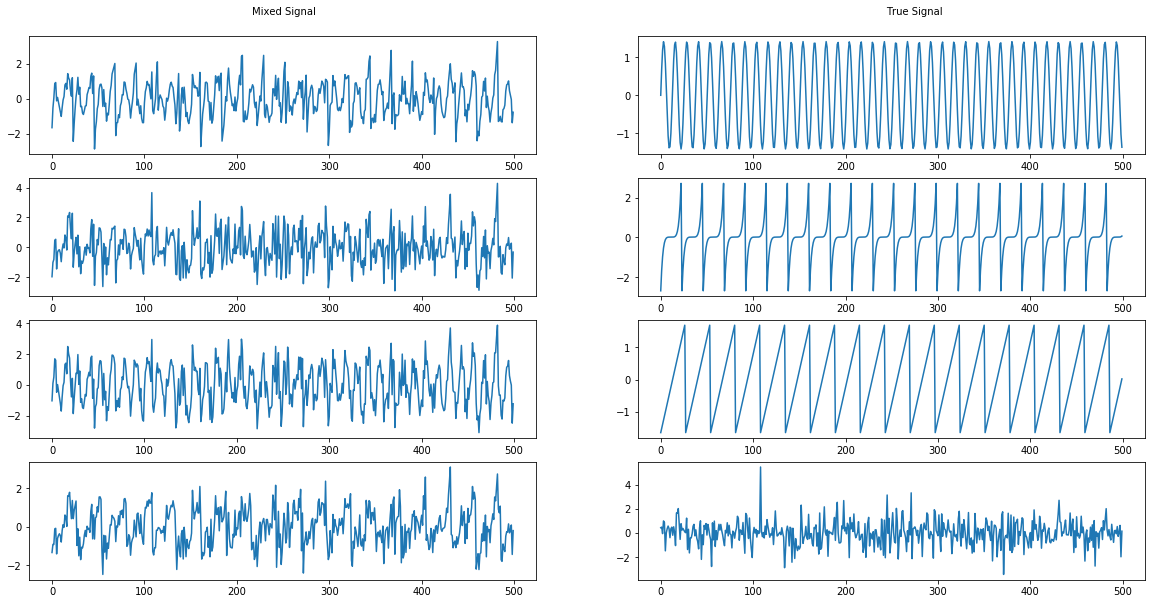

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,10))
for i in range(4):
    axes[i,0].plot(mixedsig[i,:])
    axes[i,1].plot(sigTrue[i,:])
fig.text(x=0.28, y=0.91,s="Mixed Signal")
fig.text(x = 0.72, y=0.91,s="True Signal")
plt.show()

#### Step 1: Perform PCA on data 

In [21]:
np.mean(mixedsig, axis=1) # closed to 0, treat as centered

array([2.84217094e-17, 2.66453526e-17, 4.52970994e-17, 4.26325641e-17])

In [22]:
A, W = np.linalg.eig(1/N * mixedsig @ mixedsig.T)
# convert back to whitened data
whitenedsig = np.diag(A**(-0.5)) @ W.T @ mixedsig

#### Step 2: Perform ICA through the FastICA algorithm (ref. pg411 of Murphy)  
The FastICA can be summarized as such. The latent-variable negative log prior is chosen to be $G_j(z_j) = \exp(-\frac{z_j^2}{2})$, therefore we have, $g_j(z_j) = z_j\exp(-\frac{z_j^2}{2})$ and $g'_j(z_j) = \exp(-\frac{z_j^2}{2}) - z_j^2\exp(-\frac{z_j^2}{2})$. Then we can directly apply the FastICA algorithm, 

$\mathbf{v}^* = \mathbb{E}[\mathbf{x}\sum g_j(\mathbf{v_j}^T\mathbf{x})] - \mathbb{E}[\sum g'_j(\mathbf{v_j}^T\mathbf{x})]\mathbf{v}$

In [23]:
a1 = 1.5
def g(z):
    return np.tanh(a1*z)

def g_prime(z):
    return a1 * (1/np.cosh(a1*z))**2

def G(z):
    return 1/a1 * np.log(np.cosh(a1*z))

In [24]:
def g(z):
    return z * np.exp(-0.5 * z**2)

def g_prime(z):
    return np.exp(-0.5 * z**2) - z**2 * np.exp(-0.5 * z**2)

def G(z):
    return -np.exp(-0.5 * z**2)

In [25]:
# initialise V
V = np.random.rand(D*D).reshape(D,D)
V = orth(V)
X = whitenedsig

V_new = np.zeros(V.shape)

In [26]:
# FastICA
err = 5
err_record = []
tol = 1e-10
NLL_old = 5
NLL_record = [NLL_old,]
counter = 0
vv_record = []

while True:
    A = (g(V @ X) @ X.T)/N
    B = np.sum(g_prime(V @ X), axis=1).reshape(D,1)/N
    V_new = A - B * V
    V_new = orth(V_new.T).T
    NLL_new = np.sum(G(V @ X))/N
    err = max(abs(abs(np.diag(np.dot(V_new, V.T))) - 1))
    NLL_record.append(NLL_new)
    err_record.append(err)
    vv_record.append(np.abs(np.trace(V.T @ V_new)))
    
    if err < tol:
        V = V_new
        break
    elif counter >= 500:
        print("Maximum iteration reached. Break. ")
        break
    else:
        V = V_new
        NLL_old = NLL_new
        counter += 1

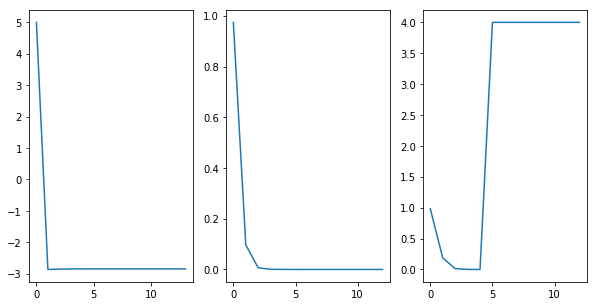

In [27]:
fig, axes = plt.subplots(ncols = 3, figsize=(10,5))
axes[0].plot(NLL_record)
axes[1].plot(err_record)
axes[2].plot(vv_record)
plt.show()

In [28]:
truesig = V @ X

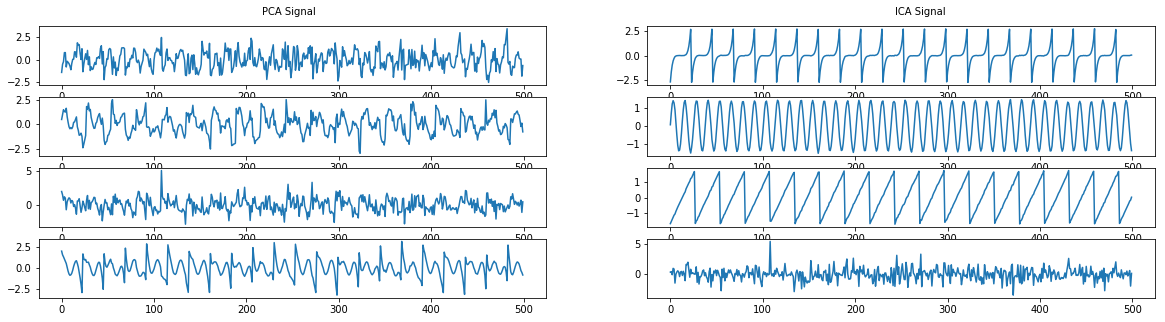

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,5))
for i in range(4):
    axes[i,0].plot(whitenedsig[i,:])
    axes[i,1].plot(-truesig[i,:])
fig.text(x=0.28, y=0.91,s="PCA Signal")
fig.text(x = 0.72, y=0.91,s="ICA Signal")
plt.show()

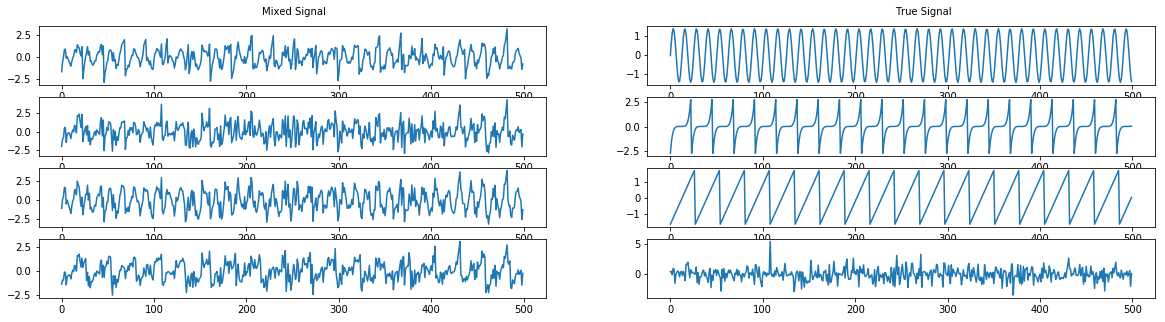

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,5))
for i in range(4):
    axes[i,0].plot(mixedsig[i,:])
    axes[i,1].plot(sigTrue[i,:])
fig.text(x=0.28, y=0.91,s="Mixed Signal")
fig.text(x = 0.72, y=0.91,s="True Signal")
plt.show()

## Problem 4: LASSO

### Part A
a). **True or False**: LASSO solutions result in sparsity in regression coefficients. Explain. 

True. This is the becuase of the nature of linear combination of coefficients in the parameter space, such that as $\lambda$ increases, some of the parameters will turn to zero. 

b). **True or False**: Ridge Regression solutions result in spartisty in the regression coefficients. Explain. 

False. Ridge regression is essential equivalent to minimizing the unregularized sum of squares of parameteres with the constraint. 

c). **True or False**: As we increase $\lambda$ in LASSO, we expect the number of variables in our solution to increase. Explain. 

False. As we increase $\lambda$, the weight of constraint increases in the objective function therefore there is a stronger tendency for sparsity. 

d). **True or False**: It is possible to achieve the least-squares solution using  aLASSO object. Explain. 

True. Since LASSO favours sparsity, for the case of a single parameter regression model, the solution from LASSO should coincide with that of the ridge regression model. 

e). **True or False**: Given any two LASSO solutions corresponding to $\lambda_1$ and $\lambda_2$ with $\lambda_2>\lambda_1$ and the same support for these two solutions, it is possible to write out a closed-form expression for all solutions correspoinding to $\lambda$ with $\lambda_1 < \lambda <\lambda_2$. Explain. 

True. For LASSO, it is possible compute the critical solutions between which a linear regularization path can be obatined, through LARS algorithm.

### Part B: Generate data and produce LASSO regression model. 

In [31]:
# Generate random data
D = 4096
K = 160
N = 1024

w0 = np.zeros((D,1))
K_pool = np.random.choice(D, size=K, replace=False)
for i in range(K):
    w0[K_pool[i],0] = (-1)**np.random.randint(2)

X = np.random.rand(N,D) - 0.5
y = X @ w0 + norm.rvs(0,0.01**2, size=(N,1))

#### Now estimate w from y and X with LASSO, with Coordinate descent

In [32]:
def soft(c,l,a):
    if c < -l:
        return (c+l)/a
    elif c > l:
        return (c-l)/a
    else:
        return 0

In [33]:
# Compute lam_max
lam_max = np.max(X.T @ y)
print("lam_max = {}".format(lam_max))

lam_max = 164.8971369427349


In [34]:
lam = 0.1 * lam_max
# Initialize w 
w = np.linalg.inv(X.T @ X + lam * np.eye(D)) @ X.T @ y
w_old = np.empty(w.shape)

In [35]:
err = 10
err_record = []
tol =1e-8
w_old[:,:] = w[:,:]
counter = 0

while True:
    for i in range(D):
        xi = X[:,i:i+1]
        yi = (y - X @ w) + xi * w[i,0]
        deltai = (xi.T @ yi)

        if deltai < -lam:
            w[i,0] = np.asscalar((deltai + lam)/(xi.T@xi))
        elif deltai > lam:
            w[i,0] = np.asscalar((deltai - lam)/(xi.T@xi))
        else:
            w[i,0] = 0
    
    
    err = np.asscalar(max(abs(w-w_old)))
    err_record.append(err)
    
    if err < tol:
        break
    elif counter > 100:
        print("MaxIter reached. Break")
        break
    else:
        w_old[:,:] = w[:,:]
        counter += 1
        print("{}: {}".format(counter, err))

1: 0.31296549630231196
2: 0.42184744902235377
3: 0.2320711134668425
4: 0.15559209336950475
5: 0.1103676663350952
6: 0.08531215713825097
7: 0.07771543259468502
8: 0.06470203083107429
9: 0.049434754318004925
10: 0.037052252128612295
11: 0.026316764460910913
12: 0.017258698976777842
13: 0.011409308882851632
14: 0.007488852908613786
15: 0.0050719710611727975
16: 0.003236392891896145
17: 0.0020742435291769
18: 0.0013341543122158406
19: 0.0008555280641490137
20: 0.0005414128316778566
21: 0.0003508716033518988
22: 0.00022470962867204847
23: 0.00014281193587550867
24: 9.052244101215301e-05
25: 5.7288106560693386e-05
26: 3.6226752655244e-05
27: 2.2897442106817323e-05
28: 1.4468569039305379e-05
29: 9.141391916656083e-06
30: 5.775539736796453e-06
31: 3.6491575109431906e-06
32: 2.3058161565669977e-06
33: 1.457109111480115e-06
34: 9.208587723463779e-07
35: 5.820004609358165e-07
36: 3.6785604839995045e-07
37: 2.325154000448748e-07
38: 1.4697391603757382e-07
39: 9.290512847925925e-08
40: 5.8728222729

In [36]:
fig, axes = plt.subplots(nrows = 2, figsize=(10,5))
axes[0].plot(w0[:,0])
axes[0].set_title("Real w")
axes[1].plot(w[:,0])
axes[1].set_title("LASSO")
fig.tight_layout()

## Problem 5: Automatic relevance determination and compressed sensing

### Part 1: Automatic relevance determination is another method that results in sparse solution. 

a). Explain (with equations and diagram) how ARD works and why it results in sparse solution. 

ARD, or Sparse Bayesian Learning in linear regression, is a method produce sparse solutions while compute the posterior over the parameters. Different from models based on latent variances, ARD compute the posterior point estimate for the variances of the measurement and the weights first, and then the posterior of weights are computed with plug-in value of the variances. Mathematically, we parameterise the model as, 
\begin{align}
p(y|\mathbf{x}, \mathbf{w}, \beta) &= \mathcal{N}(y|\mathbf{w}^T\mathbf{x}, \mathbf{1}/\beta)\\
p(\mathbf{w}) &= \mathcal{N}(\mathbf{w}|\mathbf{0},\mathbf{A}^{-1})
\end{align}

The regularized ML solution for the variances is as such, 
\begin{equation}
\mathcal{l}(\boldsymbol{\alpha}, \beta) = -\frac{1}{2}\log p(\mathbf{y}|\mathbf{X}, \boldsymbol{\alpha}, \beta) = \log |\mathbf{C}_\alpha| + \mathbf{y}^T\mathbf{C}_{\boldsymbol{\alpha}}^{-1}\mathbf{y} + \sum_j (a\log \alpha_j - b\alpha_j) + c\log\beta - d\beta
\end{equation}
Once the variances are estimated, the posterior over the parameters can be estimated with ,
\begin{align}
p(\mathbf{w}|\mathcal{D}, \hat{\boldsymbol{\alpha}}, \hat{\beta}) &= \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \\
\boldsymbol{\Sigma}^{-1} &= \hat{\beta}\mathbf{X}^T\mathbf{X} + \mathbf{A}\\
\boldsymbol{\mu} &= \hat{\beta}\boldsymbol{\Sigma}\mathbf{X}^T\mathbf{y}
\end{align}

The reason behind the sparsity is that ML-II encourage $\alpha_j \to \infty$ for irrelevant features hence the the corresponding posterior mean will have a zero value. And in ARD, the marginal likelihood punishes solutions where $\alpha_j$ is small but $\mathbf{X}{:,j}$ is irrelevant. 

b). How is ARD connected to the MAP estimate? 

While ARD is different from typical MAP estimate that the weights are integrated out to find the estimate of variances, there is a formulation that ARD can be written as the following MAP estimation. 
\begin{align}
\hat{\mathbf{w}}^{ARD} &= \text{arg}\min \beta||\mathbf{y} - \mathbf{X}\mathbf{w}||^2_2 + g_{ARD}(\mathbf{w})\\
g_{ARD}(\mathbf{w}) &= \min_{\alpha\geq 0}\sum_j \alpha_j w_j^2 + \log|\mathbf{C}_\boldsymbol{\alpha}|
\end{align}

### Part B: Compressed sensing to denoising image

First, have a look at the target image. 

![](./Resources/P5/P5.jpg)

In [37]:
image = plt.imread("Resources/P5/P5.jpg")
img_shape = image.shape

In [38]:
print("Shape of image data: {}".format(image.shape))

Shape of image data: (298, 439, 3)


#### Training the dictionary matrix from this image
The first step is to produced a dictionary from the image employing sparse encoding. In order to achieve that, we need to partition the image into overlapping patches first. Here we use 12 x 12 color patches, considering each pixel is a triple tuple, we will have 12 x 12 x 3 which is reshaped into 432 x 1 vector. 

In [40]:
image_crop = image[0:290, 0:430, :]
p_size = 50 # patch size
p_step = 10 # patch step
X_list = []

for i in range(0, img_shape[0] - p_size, p_step):
    for j in range(0, img_shape[1] - p_size, p_step):
        X_list.append(crop_image[i:i+p_size, j:j+p_size, :].reshape(p_size * p_size * 3, 1))
X = np.concatenate(X_list, axis=1)
D, N = X.shape
print(X.shape)

(2700, 109612)


The model of sparse coding is through the maximization of the likelihood, 
\begin{equation}
\log p(\mathcal{D}|\mathbf{W}) = \sum_{i=1}^N \log\int_{\mathbf{z}_i} \mathcal{N}(\mathbf{x}_i|\mathbf{W}\mathbf{z}_i, \sigma^2\mathbf{I})p(\mathbf{z}_i)d\mathbf{z}_i
\end{equation}

Enforcing a sparse prior on the latent variables, the NLL is then written as, 
\begin{equation}
\text{NLL}(\mathbf{W},\mathbf{Z}) = \sum_{i=1}^N \frac{1}{2} ||\mathbf{x}_i - \mathbf{W}\mathbf{z}_i||^2_2 + \lambda||\mathbf{z}_i||_1
\end{equation}

To prevent $\mathbf{W}$ from becoming arbitrarily large, we constraint with l2 norm to be less than or equal to 1,
\begin{equation}
\mathcal{C} = \{\mathbf{W} \in \mathbb{R}^{D\times L}\ \ \ \text{s.t.}\ \ \mathbf{w}_j^T\mathbf{w}_j \leq 1\}
\end{equation}

Since $\mathbf{W}$ and $\mathbf{Z}$ are estimated iteratively, we use the **analysis-synthesis** approach, where W is obtained from least square regression (W is orthogonalised) and z is from lasso. Here we use the regression algorithm directly from *scikit-learn* to focus on the sparse coding itself. 

We initialise $\mathbf{Z}$ with random number and then obtain the initial $\mathbf{W} = (\mathbf{Z}^T\mathbf{Z})^{-1}\mathbf{Z}^T\mathbf{X}$



L = 16
Z = np.random.rand(L,N)
W = np.linalg.inv(Z.T @ Z) @ Z.T @ X

After the dictionary is obtained, another regressio is run on the latent variable $\mathbf{z}$ to the compressed target $\mathbf{y}$, being, 
\begin{equation}
\mathbf{y} = \mathbf{R}\mathbf{W}\mathbf{z}
\end{equation}
Combining R and W to make a square matrix for direct application of the least square formula. 

Sorry I don't really have time to finish this part. 